# Collaborative Filtering
---

I'm using Movielens data which is available here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

This notebook is heavily inspired by the following notebook from fastai github repo: https://github.com/fastai/fastai/blob/master/courses/dl1/lesson5-movielens.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()
from IPython.core.debugger import set_trace #debugging
#fastai library imports: https://github.com/fastai/fastai
from fastai.learner import *
from fastai.column_data import *

Loading BokehJS ...

In [2]:
# from tqdm import tqdm as tqdm_cls
# inst = tqdm_cls._instances
# for i in range(len(inst)): inst.pop().close()

----

## Reading the data

In [3]:
path='data/movielens/ml-latest-small/' #path to the dataset

We are looking at 2 files: ratings and movies. Ratings contain rating by different users for different movies along with timestamp. Movies contains metadata about movies. movieid is the key to join the 2 datasets. No metadata for userid is available

In [4]:
ratings = pd.read_csv(f'{path}ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
movies = pd.read_csv(f'{path}movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings = ratings.drop(['timestamp'],axis = 1) #dropping the timestamp variable..not important for this study

In [7]:
len(ratings) #100004 rows in our dataset

100004

---

## Collaborative filtering using fastai

For this section refer to this article: https://medium.com/p/919da17ecefb/edit

### Training

In [8]:
val_idxs = get_cv_idxs(len(ratings)) #get validation indices (default 20% of data)
wd=2e-4 #weight decay
n_factors = 50 #how big embedding matrix we want

In [9]:
len(val_idxs)

20000

In [10]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating') #creating a custom dataloader
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam) #create a learner (model) and specify the batch size and optimizer

In [11]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True) #training with learning rate as 1e-2

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.86094  0.83524]                                    
[ 1.       0.66514  0.8792 ]                                    
[ 2.       0.31946  0.83188]                                    



Above we can see training and validation MSE after each epoch

### Prediction on validation

In [12]:
preds = learn.predict() #this will predict ratings for validation dataset

In [13]:
preds

array([ 2.96787,  3.32698,  2.53395, ...,  3.80088,  2.91533,  3.68756], dtype=float32)

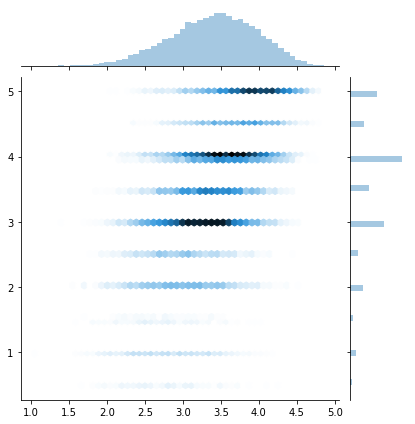

In [14]:
y=learn.data.val_y #actual ratings for validation
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [15]:
math.sqrt(metrics.mean_squared_error(y,preds)) #RMSE for validation data

0.9115292258167741

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. So we are at par with the benchmarks for this dataset.

---

## Interpreting embeddings and biases

In [16]:
from sklearn.manifold import TSNE

In [17]:
movies = pd.read_csv(f'{path}movies.csv')

In [18]:
movie_names = movies.set_index('movieId')['title'].to_dict() #creating dictionary of movieid: movie title
g=ratings.groupby('movieId')['rating'].count() #counting the number of ratings for each movie
topMovies=g.sort_values(ascending=False).index.values[:3000] #top 3000 movies based on number of ratings
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies]) #id for the top movies to link it to the embedding and bias matrix created by the model

In [19]:
m=learn.model; m.cuda() 

EmbeddingDotBias (
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

u: Embedding matrix for users, i: Embedding matrix for movies, ub: Bias matrix for users, ib: bias matrix for movies

### Movie embeddings

In [20]:
movie_emb = to_np(m.i(V(topMovieIdx))) #converting the torch embedding to numpy matrix
movie_emb.shape

(3000, 50)

### t-SNE

In [21]:
#t-sne on embedding vectors
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(movie_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.005s...
[t-SNE] Computed neighbors for 3000 samples in 1.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.421800
[t-SNE] KL divergence after 50 iterations with early exaggeration: 79.346962
[t-SNE] Error after 1000 iterations: 3.042393


In [22]:
#preparing dataframe for visualization
df_combine = pd.DataFrame([movie_names[i] for i in topMovies])
df_combine.columns = ['title']
df_combine['x-tsne'] = tsne_results[:,0]
df_combine['y-tsne'] = tsne_results[:,1]

In [24]:
df_combine.head()

,title,x-tsne,y-tsne
0,Forrest Gump (1994),9.188692,0.920415
1,Pulp Fiction (1994),-1.338275,-12.899643
2,"Shawshank Redemption, The (1994)",9.932871,-10.151700
3,"Silence of the Lambs, The (1991)",-21.067549,-1.708968
4,Star Wars: Episode IV - A New Hope (1977),1.961918,-21.877657


### Visualizing t-SNE components of embeddings using Bokeh

In [102]:
source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title']
))

In [103]:
    title = 'T-SNE visualization of embeddings'

    plot_lda = figure(plot_width=1000, plot_height=600,
                         title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                         x_axis_type=None, y_axis_type=None, min_border=1)

    plot_lda.scatter(x='x', y='y',source=source,
                    alpha=0.4, size=10)

    # hover tools
    hover = plot_lda.select(dict(type=HoverTool))
    hover.tooltips = {"content": "Title: @title"}
    

    show(plot_lda)
    save(plot_lda, 't-SNE_emb.html') #this will save the plot as html

/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/home/ec2-user/projects/collaborative-filtering/t-SNE_emb.html'

---

### Cosine similarity in embedding space

Here I'm trying to find the most similar movies based on cosine similarity between the embedding vector of a given movie and each of the remaining movies

In [27]:
def cos_sim(a, b):
	"""Takes 2 vectors a, b and returns the cosine similarity according 
	to the definition of the dot product
	"""
	dot_product = np.dot(a, b)
	norm_a = np.linalg.norm(a)
	norm_b = np.linalg.norm(b)
	return dot_product / (norm_a * norm_b)

In [28]:
title2emb = pd.DataFrame([movie_names[i] for i in topMovies])
title2emb.columns = ['title']
title2emb = pd.concat([title2emb,pd.DataFrame(movie_emb)],axis =1)

In [31]:
title2emb.head()

,title,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,Forrest Gump (1994),0.132553,-0.463755,-0.358955,0.191023,-0.294693,-0.035143,-0.076551,-0.119772,0.236667,...,-0.112795,0.352216,-0.145015,0.056974,0.034254,-0.063725,0.132152,-0.156047,0.163847,0.283221
1,Pulp Fiction (1994),-0.415060,-0.023127,-0.141066,-0.327475,0.051329,-0.144074,0.227163,0.225916,0.267689,...,0.317953,-0.149422,0.231067,-0.445028,-0.095614,-0.143240,0.186093,0.053340,-0.092111,-0.035886
2,"Shawshank Redemption, The (1994)",-0.433478,-0.714720,-0.398814,-0.207088,-0.421486,0.053935,-0.014080,-0.153374,0.046320,...,0.118761,-0.196672,0.308081,0.001527,-0.316373,-0.197614,0.143832,-0.137705,0.008196,-0.254397
3,"Silence of the Lambs, The (1991)",-0.623644,-0.143302,-0.114493,-0.128616,0.305142,-0.049059,0.051439,-0.151523,-0.277529,...,-0.045791,0.120306,-0.205398,-0.350030,-0.031686,-0.499647,-0.059803,-0.082755,0.264671,0.182469
4,Star Wars: Episode IV - A New Hope (1977),-0.367971,-0.200984,-0.150570,-0.244955,0.450810,-0.258104,0.374088,-0.195119,-0.262306,...,0.064634,0.372440,0.144534,-0.068486,0.178061,-0.168988,0.563224,0.436979,0.056429,0.035499


In [40]:
base_movie = 'Gone Girl (2014)'
base_emb = title2emb[title2emb['title']==base_movie].iloc[:,1:].values #embedding vector for the base movie
movie_list = title2emb.title
cos_sim_dict = {i:cos_sim(np.squeeze(base_emb),np.squeeze(title2emb[title2emb['title']==i].iloc[:,1:].values)) for i in movie_list}
sorted(cos_sim_dict.items(), key=itemgetter(1),reverse=True)[:15] #movies sorted by cosine similarity to the base movie

[('Gone Girl (2014)', 1.0000001),
 ('Fish Called Wanda, A (1988)', 0.64800227),
 ('Michael Clayton (2007)', 0.6277588),
 ('Kick-Ass (2010)', 0.56094319),
 ('Perks of Being a Wallflower, The (2012)', 0.54713261),
 ('Moneyball (2011)', 0.54281408),
 ('Raging Bull (1980)', 0.53750366),
 ('Wolf of Wall Street, The (2013)', 0.52780879),
 ('Black Mirror (2011)', 0.51961553),
 ('*batteries not included (1987)', 0.51567692),
 ('Quiz Show (1994)', 0.51305813),
 ('Broadcast News (1987)', 0.50754493),
 ('Nightcrawler (2014)', 0.50734043),
 ('Midnight Cowboy (1969)', 0.50710261),
 ('When Harry Met Sally... (1989)', 0.50631022)]

---

### Movie bias

Movie bias can be considered as a measure of actual ranking of movie adjusting for the different behavior and rating patterns of different users. Some users tend to rate conservatively and some very liberally

In [28]:
movie_bias = to_np(m.ib(V(topMovieIdx))) #extracting the movie bias from the trained model for 3000 movies

In [29]:
movie_bias

array([[ 0.56386],
       [ 0.58052],
       [ 0.89905],
       ..., 
       [ 0.17783],
       [-0.05643],
       [ 0.24458]], dtype=float32)

In [43]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

In [44]:
sorted(movie_ratings, key=lambda o: o[0])[:15] #worst movies based on bias ranking

[(-0.65091091, 'Battlefield Earth (2000)'),
 (-0.55419731, 'Super Mario Bros. (1993)'),
 (-0.48237324, 'Inspector Gadget (1999)'),
 (-0.48013669, 'Congo (1995)'),
 (-0.47606534, 'Anaconda (1997)'),
 (-0.46266866, 'Wild Wild West (1999)'),
 (-0.45456645, "Joe's Apartment (1996)"),
 (-0.4406811, 'Speed 2: Cruise Control (1997)'),
 (-0.42358428, 'Dungeons & Dragons (2000)'),
 (-0.41145059, 'Avengers, The (1998)'),
 (-0.40174344, 'Vertical Limit (2000)'),
 (-0.40039924, 'Halloween III: Season of the Witch (1982)'),
 (-0.39847854, 'Howard the Duck (1986)'),
 (-0.3946788, 'Batman & Robin (1997)'),
 (-0.39254996,
  'Halloween: The Curse of Michael Myers (Halloween 6: The Curse of Michael Myers) (1995)')]

In [45]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15] #top movies based on bias ranking

[(0.93213588, 'Shawshank Redemption, The (1994)'),
 (0.6943925, 'Usual Suspects, The (1995)'),
 (0.65349036, 'Silence of the Lambs, The (1991)'),
 (0.63245183, 'Godfather, The (1972)'),
 (0.63078701, 'Pulp Fiction (1994)'),
 (0.62218958, 'Matrix, The (1999)'),
 (0.61202615, "Schindler's List (1993)"),
 (0.61053628,
  'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)'),
 (0.60196024, 'American Beauty (1999)'),
 (0.5965603, '12 Angry Men (1957)'),
 (0.58712071, 'Princess Bride, The (1987)'),
 (0.5869571, 'Fargo (1996)'),
 (0.58132416, 'Godfather: Part II, The (1974)'),
 (0.57270211, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.56373489, 'Pianist, The (2002)')]

---

### Looking at a particular user

In this section we'll look at a particular user and then cluster the movie embedding vectors by the ratings assigned by that particular user and look for any patterns

In [88]:
u=ratings.groupby('userId')['rating'].count()
topusers=u.sort_values(ascending=False).index.values[:100]
topusersIdx = np.array([cf.user2idx[o] for o in topusers])

In [90]:
topusers

array([547, 564, 624,  15,  73, 452, 468, 380, 311,  30, 294, 509, 580, 213, 212, 472, 388,  23, 457, 518,
       461, 232, 102, 262, 475, 306, 119, 654, 358, 529, 575, 105,  56, 353, 664,  48, 587, 596, 165, 384,
       195, 463, 605, 481, 665, 607,  19, 199, 285, 150, 405, 268, 242, 505, 615, 480, 514, 130, 299,  17,
       423, 574, 111, 346, 157, 187, 407, 128, 402,  77, 382, 598, 134, 355, 537, 243, 430, 534, 313, 585,
        95, 608, 561, 427, 239, 220, 247, 312, 460, 387, 577, 292, 544, 431, 652,  78, 439, 176, 648,  88])

In [46]:
user_547 = ratings[ratings['userId']==547] #user with the highest number of ratings
u547MovieIdx = np.array([cf.item2idx[o] for o in user_547.movieId]) #id for the top movies to link it to the embedding and bias matrix created by the model
u547Ratings = user_547.rating
movie_emb_u547 = to_np(m.i(V(u547MovieIdx))) #converting the torch embedding to numpy matrix

In [50]:
df_combine_u547 = pd.DataFrame([movie_names[i] for i in user_547.movieId])
df_combine_u547.columns = ['title']
df_combine_u547 = pd.concat([df_combine_u547,pd.DataFrame(movie_emb_u547)],axis=1)

In [54]:
df_combine_u547.head()

,title,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,Toy Story (1995),-0.319952,-0.153453,0.402057,0.046731,-0.198464,0.082833,0.091520,-0.055316,0.091780,...,0.270638,0.101837,-0.097867,-0.194169,0.140290,-0.058537,0.290413,-0.172116,0.450979,0.154015
1,Heat (1995),0.173140,-0.374734,-0.034256,-0.325415,-0.285656,-0.067157,0.110015,-0.135461,-0.213825,...,0.329661,-0.080686,0.282866,0.038345,0.025007,-0.156560,0.132324,-0.038206,0.203375,0.262010
2,Sabrina (1995),0.031411,0.169822,-0.277031,-0.150907,0.241624,0.081316,0.059789,0.058588,-0.177269,...,-0.056116,0.288322,0.080993,0.302002,0.158289,0.286157,0.115834,-0.100609,0.204727,-0.077644
3,"American President, The (1995)",0.159103,-0.156947,-0.169002,-0.211603,-0.106786,0.012457,-0.168632,0.035421,-0.417987,...,-0.245929,-0.401398,-0.217543,-0.074168,0.436061,0.047165,0.330946,0.106014,0.198659,0.191297
4,Nixon (1995),0.177666,0.312977,0.018249,-0.119018,0.022998,-0.216762,0.073691,-0.037366,-0.060351,...,0.090738,0.097473,0.432303,-0.063113,-0.137830,0.001271,0.103631,0.191715,-0.044846,0.205121


In [56]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(movie_emb_u547)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2391 samples in 0.004s...
[t-SNE] Computed neighbors for 2391 samples in 0.705s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2391
[t-SNE] Computed conditional probabilities for sample 2000 / 2391
[t-SNE] Computed conditional probabilities for sample 2391 / 2391
[t-SNE] Mean sigma: 0.170253
[t-SNE] KL divergence after 50 iterations with early exaggeration: 75.806282
[t-SNE] Error after 1000 iterations: 2.133561


In [57]:
df_combine_u547['x-tsne'] = tsne_results[:,0]
df_combine_u547['y-tsne'] = tsne_results[:,1]

In [59]:
df_combine_u547.head()

,title,0,1,2,3,4,5,6,7,8,...,42,43,44,45,46,47,48,49,x-tsne,y-tsne
0,Toy Story (1995),-0.319952,-0.153453,0.402057,0.046731,-0.198464,0.082833,0.091520,-0.055316,0.091780,...,-0.097867,-0.194169,0.140290,-0.058537,0.290413,-0.172116,0.450979,0.154015,16.954386,13.342017
1,Heat (1995),0.173140,-0.374734,-0.034256,-0.325415,-0.285656,-0.067157,0.110015,-0.135461,-0.213825,...,0.282866,0.038345,0.025007,-0.156560,0.132324,-0.038206,0.203375,0.262010,2.029821,-23.294428
2,Sabrina (1995),0.031411,0.169822,-0.277031,-0.150907,0.241624,0.081316,0.059789,0.058588,-0.177269,...,0.080993,0.302002,0.158289,0.286157,0.115834,-0.100609,0.204727,-0.077644,14.385095,3.537281
3,"American President, The (1995)",0.159103,-0.156947,-0.169002,-0.211603,-0.106786,0.012457,-0.168632,0.035421,-0.417987,...,-0.217543,-0.074168,0.436061,0.047165,0.330946,0.106014,0.198659,0.191297,13.703283,8.344221
4,Nixon (1995),0.177666,0.312977,0.018249,-0.119018,0.022998,-0.216762,0.073691,-0.037366,-0.060351,...,0.432303,-0.063113,-0.137830,0.001271,0.103631,0.191715,-0.044846,0.205121,8.496047,6.152605


In [60]:
df_combine_u547['rating'] = user_547.rating.reset_index()['rating']

In [61]:
df_combine_u547.head()

,title,0,1,2,3,4,5,6,7,8,...,43,44,45,46,47,48,49,x-tsne,y-tsne,rating
0,Toy Story (1995),-0.319952,-0.153453,0.402057,0.046731,-0.198464,0.082833,0.091520,-0.055316,0.091780,...,-0.194169,0.140290,-0.058537,0.290413,-0.172116,0.450979,0.154015,16.954386,13.342017,3.5
1,Heat (1995),0.173140,-0.374734,-0.034256,-0.325415,-0.285656,-0.067157,0.110015,-0.135461,-0.213825,...,0.038345,0.025007,-0.156560,0.132324,-0.038206,0.203375,0.262010,2.029821,-23.294428,2.5
2,Sabrina (1995),0.031411,0.169822,-0.277031,-0.150907,0.241624,0.081316,0.059789,0.058588,-0.177269,...,0.302002,0.158289,0.286157,0.115834,-0.100609,0.204727,-0.077644,14.385095,3.537281,2.0
3,"American President, The (1995)",0.159103,-0.156947,-0.169002,-0.211603,-0.106786,0.012457,-0.168632,0.035421,-0.417987,...,-0.074168,0.436061,0.047165,0.330946,0.106014,0.198659,0.191297,13.703283,8.344221,3.0
4,Nixon (1995),0.177666,0.312977,0.018249,-0.119018,0.022998,-0.216762,0.073691,-0.037366,-0.060351,...,-0.063113,-0.137830,0.001271,0.103631,0.191715,-0.044846,0.205121,8.496047,6.152605,3.5


### Visualizing t-SNE components of embeddings using Bokeh

In [63]:
df_combine_u547['rating_bin'] = pd.cut(df_combine_u547.rating,5,labels=[0,1,2,3,4]) #creating bins from the ratings

In [64]:
df_combine_u547.head()

,title,0,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,x-tsne,y-tsne,rating,rating_bin
0,Toy Story (1995),-0.319952,-0.153453,0.402057,0.046731,-0.198464,0.082833,0.091520,-0.055316,0.091780,...,0.140290,-0.058537,0.290413,-0.172116,0.450979,0.154015,16.954386,13.342017,3.5,3
1,Heat (1995),0.173140,-0.374734,-0.034256,-0.325415,-0.285656,-0.067157,0.110015,-0.135461,-0.213825,...,0.025007,-0.156560,0.132324,-0.038206,0.203375,0.262010,2.029821,-23.294428,2.5,2
2,Sabrina (1995),0.031411,0.169822,-0.277031,-0.150907,0.241624,0.081316,0.059789,0.058588,-0.177269,...,0.158289,0.286157,0.115834,-0.100609,0.204727,-0.077644,14.385095,3.537281,2.0,1
3,"American President, The (1995)",0.159103,-0.156947,-0.169002,-0.211603,-0.106786,0.012457,-0.168632,0.035421,-0.417987,...,0.436061,0.047165,0.330946,0.106014,0.198659,0.191297,13.703283,8.344221,3.0,2
4,Nixon (1995),0.177666,0.312977,0.018249,-0.119018,0.022998,-0.216762,0.073691,-0.037366,-0.060351,...,-0.137830,0.001271,0.103631,0.191715,-0.044846,0.205121,8.496047,6.152605,3.5,3


In [94]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'black'} #assigning colors for each bin

In [95]:
df_combine_u547['colors'] = df_combine_u547['rating_bin'].apply(lambda l: cluster_colors[l]) #creating color column in the df

In [96]:
df_combine_u547.head()

,title,0,1,2,3,4,5,6,7,8,...,45,46,47,48,49,x-tsne,y-tsne,rating,rating_bin,colors
0,Toy Story (1995),-0.319952,-0.153453,0.402057,0.046731,-0.198464,0.082833,0.091520,-0.055316,0.091780,...,-0.058537,0.290413,-0.172116,0.450979,0.154015,16.954386,13.342017,3.5,3,red
1,Heat (1995),0.173140,-0.374734,-0.034256,-0.325415,-0.285656,-0.067157,0.110015,-0.135461,-0.213825,...,-0.156560,0.132324,-0.038206,0.203375,0.262010,2.029821,-23.294428,2.5,2,yellow
2,Sabrina (1995),0.031411,0.169822,-0.277031,-0.150907,0.241624,0.081316,0.059789,0.058588,-0.177269,...,0.286157,0.115834,-0.100609,0.204727,-0.077644,14.385095,3.537281,2.0,1,green
3,"American President, The (1995)",0.159103,-0.156947,-0.169002,-0.211603,-0.106786,0.012457,-0.168632,0.035421,-0.417987,...,0.047165,0.330946,0.106014,0.198659,0.191297,13.703283,8.344221,3.0,2,yellow
4,Nixon (1995),0.177666,0.312977,0.018249,-0.119018,0.022998,-0.216762,0.073691,-0.037366,-0.060351,...,0.001271,0.103631,0.191715,-0.044846,0.205121,8.496047,6.152605,3.5,3,red


In [97]:
top_labels = {0: 'V. Low', 1:'Low', 2:'Medium', 3:'High',4:'V.High'} #actual range of bins

In [104]:
source = ColumnDataSource(dict(
    x=df_combine_u547['x-tsne'],
    y=df_combine_u547['y-tsne'],
    title= df_combine_u547['title'], #title for tool tip
    colors = df_combine_u547['colors'], #colors for each point according to cluster/bin
    label=df_combine_u547['rating_bin'].apply(lambda l: top_labels[l]) #label for each cluster/bin
))

In [105]:
title = 'T-SNE visualization of embeddings- cluster by user rating (userID:547)'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,legend='label',
                alpha=0.8, color='colors',)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}

plot_lda.legend.location = "top_left"
plot_lda.legend.orientation = "horizontal"
show(plot_lda)
save(plot_lda, 't-SNE_cluster_rating.html')

/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/home/ec2-user/projects/collaborative-filtering/t-SNE_cluster_rating.html'

---

### Embeddings cluster by bias

In [84]:
from bokeh.models import Legend

In [30]:
df_combine['bias'] = movie_bias

In [31]:
df_combine['bias_bin'] = pd.cut(df_combine.bias,5,labels=[0,1,2,3,4])

In [32]:
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'black'}

df_combine['colors'] = df_combine['bias_bin'].apply(lambda l: cluster_colors[l])

df_combine.head()

top_labels1 = {0: 'V. Low', 1:'Low', 2:'Medium', 3:'High',4:'V.High'}

In [107]:
source = ColumnDataSource(dict(
    x=df_combine['x-tsne'],
    y=df_combine['y-tsne'],
    title= df_combine['title'],
    colors = df_combine['colors'],
    label=df_combine['bias_bin'].apply(lambda l: top_labels1[l])

))

title = 'T-SNE visualization of embeddings - cluster by bias'

plot_lda = figure(plot_width=1000, plot_height=800,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y',source=source,legend='label',
                alpha=0.8, color='colors')

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title"}


plot_lda.legend.location = "top_left"

plot_lda.legend.orientation = "horizontal"

show(plot_lda)
save(plot_lda, 't-SNE_emb_cluster_bias.html')

/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/bokeh/io/saving.py:125: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/ec2-user/anaconda3/envs/fastai/lib/python3.6/site-packages/bokeh/io/saving.py:138: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/home/ec2-user/projects/collaborative-filtering/t-SNE_emb_cluster_bias.html'

---

----

## Collaborative filtering from scratch using pytorch and fastai

### Data loading

In [4]:
path='data/movielens/ml-latest-small/'

In [5]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
val_idxs = get_cv_idxs(len(ratings)) #20% validation 
n_factors = 50 #how big embedding matrix we want

### Collaborative filtering as a dot product model

Converting the userid and movieid (unique) to contiguous indices starting from 0 for creation of embedding matrix

This is pytorch/fastai implementation of this collaborative filtering as discussed in this article: https://medium.com/p/63b00b9739ce/edit

In [8]:
u_unique = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_unique)} #dictionary comprehension
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

In [9]:
m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)} 
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [10]:
n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [11]:
n_users,n_movies

(671, 9066)

We have 671 unique users and 9066 unique movies

Specifying dependent and independent variables. In our case rating is the dependent variable. We are dropping timestamp as it doesn't seem to be a helpful variable

In [15]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32) #pytorch requires every input to be of type float32

Creating dataset using fastai custom dataloader

In [16]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

This data return a batch containing 3 things: categorical predictor variables, continuous predictor variables, dependent variable

In [17]:
xmb,ymb,zmb = next(iter(data.trn_dl)) #storing a mini-batch 

In [18]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

### Defining the model class

In [128]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf) #creating embedding matrix of a given size
    e.weight.data.uniform_(-0.01,0.01) #initializing values within embedding matrix.Kaiming He initialization 
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]] #defining embedding matrix and bias matrix
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1] 
        um = (self.u(users)* self.m(movies)).sum(1) #dot product of embedding vectors
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() #addition of bias
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [129]:
model = EmbeddingDotBias(n_users, n_movies).cuda()

In [130]:
wd=2e-4 #weight decay

We are using optimizer as SGD with momentum, weight decay of 2e-4 (a regularization hyperparamter) and learning rate of 1e-1

In [131]:
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9) 

Training for 3 epochs with mse loss to minimize

In [132]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.80408  0.83655]                                    
[ 1.       0.84924  0.81539]                                    
[ 2.       0.75829  0.81066]                                    



Changing the learning rate to 1e-2

In [133]:
set_lrs(opt, 1e-2)

Training for 3 more epochs

In [134]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.76492  0.80382]                                    
[ 1.       0.77785  0.80261]                                    
[ 2.       0.75358  0.80125]                                    



In [66]:
# predict(model,data.val_dl) 

array([ 2.4415 ,  3.9747 ,  3.20114, ...,  4.0431 ,  3.61654,  3.80311], dtype=float32)

---

### Collaborative filtering using Neural Networks

* We can concatenate the embedding vector of user and movie as one single vector
* Apply linear layer
* Apply RELU and dropouts
* Apply sigmoid finally

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh) 
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [12]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [19]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.8919   0.80914]                                    
[ 1.       0.81047  0.79438]                                    
[ 2.       0.79648  0.78522]                                    



In [20]:
set_lrs(opt, 1e-3)

In [21]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.75278  0.78853]                                    
[ 1.       0.78612  0.79198]                                    
[ 2.       0.74658  0.79357]                                    



In [23]:
#t-sne on embedding vectors
tsne = TSNE(n_components=3, verbose=1, perplexity=30, n_iter=1000,learning_rate=10)
tsne_results = tsne.fit_transform(movie_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.005s...
[t-SNE] Computed neighbors for 3000 samples in 1.004s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.421800
[t-SNE] KL divergence after 50 iterations with early exaggeration: 79.346962
[t-SNE] Error after 1000 iterations: 2.910956


In [24]:
#preparing dataframe for visualization
df_combine = pd.DataFrame([movie_names[i] for i in topMovies])
df_combine.columns = ['title']
df_combine['x-tsne'] = tsne_results[:,0]
df_combine['y-tsne'] = tsne_results[:,1]
df_combine['z-tsne'] = tsne_results[:,2]

In [33]:
df_combine.to_csv('t-sne1.csv',index=False)

In [35]:
FileLink('t-sne1.csv')

/home/ec2-user/projects/collaborative-filtering/t-sne1.csv